<a href="https://colab.research.google.com/github/jaadu-1/Algo-trading/blob/main/Earnings-Based_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtrader yfinance

import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 10.8 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload earnings_data_large.csv


Saving earnings_data_large.csv to earnings_data_large (1).csv


In [4]:
# 📄 Load earnings surprise data
earn_df = pd.read_csv('earnings_data_large.csv', parse_dates=['Date'])

# 🔎 Get unique tickers from the earnings file
tickers = earn_df['Ticker'].unique()

# 📊 Create a dictionary to hold merged price + earnings data
merged_data = {}

for ticker in tickers:
    print(f"📥 Downloading data for {ticker}...")

    # ⬇ Download historical stock price data
    price_df = yf.download(ticker, start='2023-01-01', end='2024-01-01')

    # ✅ Fix column levels from yfinance (remove multi-index)
    price_df.columns = price_df.columns.get_level_values(0)
    price_df.index.name = 'Date'
    price_df.reset_index(inplace=True)

    # 📎 Filter earnings for this ticker
    ticker_earnings = earn_df[earn_df['Ticker'] == ticker].copy()

    # 🧠 Calculate earnings surprise
    ticker_earnings['EarningsSurprise'] = (
        (ticker_earnings['ActualEPS'] - ticker_earnings['EstimatedEPS']) /
        ticker_earnings['EstimatedEPS']
    )

    # 🔄 Merge price data with earnings surprise
    merged = pd.merge(price_df, ticker_earnings[['Date', 'EarningsSurprise']], on='Date', how='left')
    merged['EarningsSurprise'].fillna(0.0, inplace=True)
    merged.set_index('Date', inplace=True)

    # ✅ Save merged data for this ticker
    merged_data[ticker] = merged


/tmp/ipython-input-4-4283387731.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(ticker, start='2023-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed

📥 Downloading data for AAPL...
📥 Downloading data for MSFT...



/tmp/ipython-input-4-4283387731.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['EarningsSurprise'].fillna(0.0, inplace=True)
/tmp/ipython-input-4-4283387731.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(ticker, start='2023-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4-4283387731.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained ass

📥 Downloading data for GOOGL...



/tmp/ipython-input-4-4283387731.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['EarningsSurprise'].fillna(0.0, inplace=True)


In [5]:
# 🔧 Custom PandasData class to include earnings surprise
class PandasData(bt.feeds.PandasData):
    lines = ('earningssurprise',)
    params = (('earningssurprise', -1),)


In [6]:
# 📈 Earnings surprise strategy: Buy if surprise > 10%, hold for 3 days
class EarningsStrategy(bt.Strategy):
    params = dict(hold_days=3)

    def __init__(self):
        self.order = None
        self.hold_counter = 0

    def next(self):
        surprise = self.datas[0].earningssurprise[0]

        if self.position:
            self.hold_counter += 1
            if self.hold_counter >= self.p.hold_days:
                self.close()
                self.hold_counter = 0
        elif surprise > 0.1:
            self.buy()
            self.hold_counter = 0


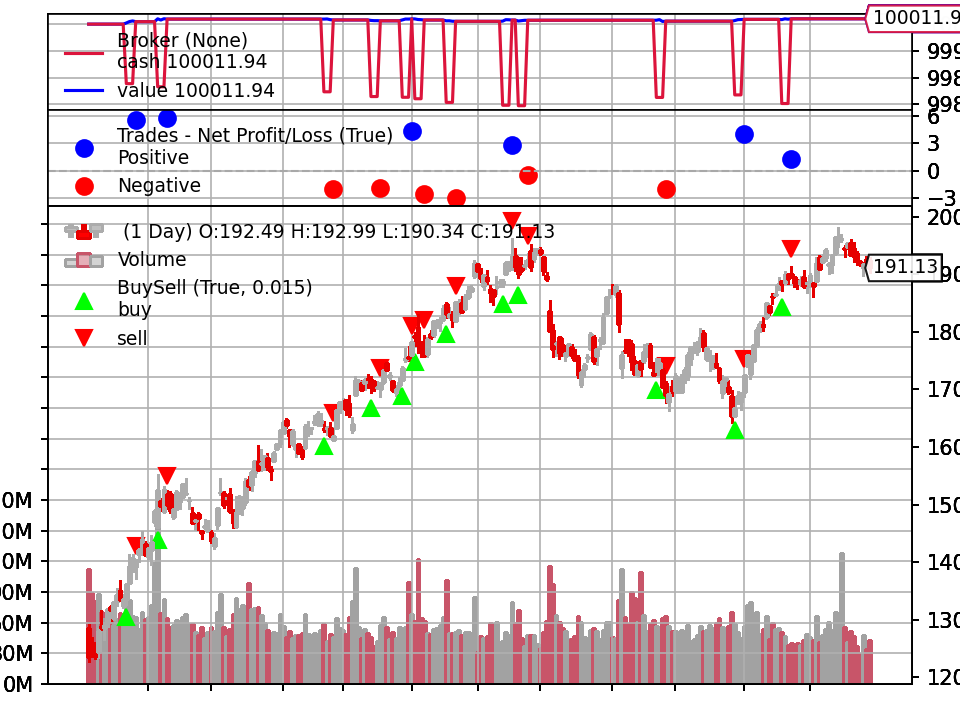

In [10]:
# ✅ Choose a stock to test — can be 'AAPL', 'MSFT', or 'GOOGL'
ticker = 'AAPL'
df = merged_data[ticker]

# 📊 Load data into Backtrader
data = PandasData(dataname=df)

# 🔁 Set up and run the backtest
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(EarningsStrategy)
cerebro.broker.set_cash(100000)

# 🚀 Run backtest
results = cerebro.run()

# 🖼️ Fix for Colab: Save and display plot
import matplotlib
matplotlib.use('Agg')  # Prevent backend conflicts

import matplotlib.pyplot as plt

# 📈 Plot and save to file
fig = cerebro.plot(style='candlestick')[0][0]
fig.savefig("backtest_plot.png", dpi=150)

# 📤 Display plot in Colab
from IPython.display import Image
Image(filename="backtest_plot.png")
